In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import math, os
from itertools import product
from multiprocessing import Pool
from functions import*

import time
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib
import copy
import pdb

In [2]:
def train(num_episodes,c,discount, LR =0.0001 ):
    torch.manual_seed(9)
    V = torch.Tensor([3,2,1])
    T = 20
    r = 0.0
    gamma = 0.98
    a = boulware(V,T,c,r)
    Net = receive_net_ANN()
    optimizer = optim.Adam(Net.parameters(),
                               LR)
    losses = np.zeros(num_episodes)
    rewards_aggregate = np.zeros(num_episodes)
    times = np.zeros(num_episodes)
    start = time.time()
    loss = 0

    path = "c{}-d{}".format(c,discount)
    if not os.path.exists(path):
        os.mkdir(path)
        os.mkdir(path+"/data")

    for ep in range(num_episodes):
        if ep % 500 == 0:
            print("Epoch ", ep, "  with loss at ", loss)
            print("Episode Time is: ", time.time() - start)
            start = time.time()
            output_training_metrics(ep,Net,a,path)
        states  = []
        actions = []
        rewards = []

        t = 0
        accepted = False
        while not accepted and t < 20:
            your_offer = torch.cat((1 - a.generate_offer(t)[:3], torch.Tensor([t])))
            states.append(your_offer)
            accepted = Net.choose_action(your_offer.unsqueeze(0))
            actions.append(accepted)
            t += 1

        t_final = t - 1
        times[ep] = t_final

        if t == 20:
            final_reward = torch.Tensor([-1])
        else:
            final_reward = torch.sum(your_offer[:3] * Net.V) * discount**t_final

        for i in range(t):
            r = gamma**(t_final-i) * final_reward
            rewards.append(r)

        states_tensor = torch.stack(states)
        actions_tensor = torch.stack(actions).squeeze()
        rewards_tensor = torch.stack(rewards)

        for __ in range(10):
            logits, vals = Net(states_tensor)
            # Critic Loss
            td = rewards_tensor - vals.squeeze()
            c_loss = td.pow(2)

            ## Receive Loss
            probs = F.softmax(logits, dim=1)
            m = Net.m_rec(probs)
            exp_v = m.log_prob(actions_tensor).squeeze() * td.detach()
            a_loss = -exp_v

            loss = (c_loss + a_loss).mean()
            losses[ep] = loss
            rewards_aggregate[ep] = final_reward

            optimizer.zero_grad()
            a_loss.mean().backward(retain_graph = True)
            c_loss.mean().backward()
            optimizer.step()

    np.save(path + "/c{}-d{}-losses".format(c,discount), losses)
    np.save(path + "/c{}-d{}-times".format(c,discount),  times)
    np.save(path + "/c{}-d{}-rewards".format(c,discount),  rewards_aggregate)
    torch.save(Net.state_dict(),path + ".th")
    return Net

Created Action Space
Epoch  0   with loss at  0
Episode Time is:  0.00010657310485839844
Epoch  500   with loss at  tensor(0.0374, grad_fn=<MeanBackward1>)
Episode Time is:  49.755268573760986
Epoch  1000   with loss at  tensor(1.0717, grad_fn=<MeanBackward1>)
Episode Time is:  60.15322232246399
Epoch  1500   with loss at  tensor(0.3167, grad_fn=<MeanBackward1>)
Episode Time is:  67.59465956687927


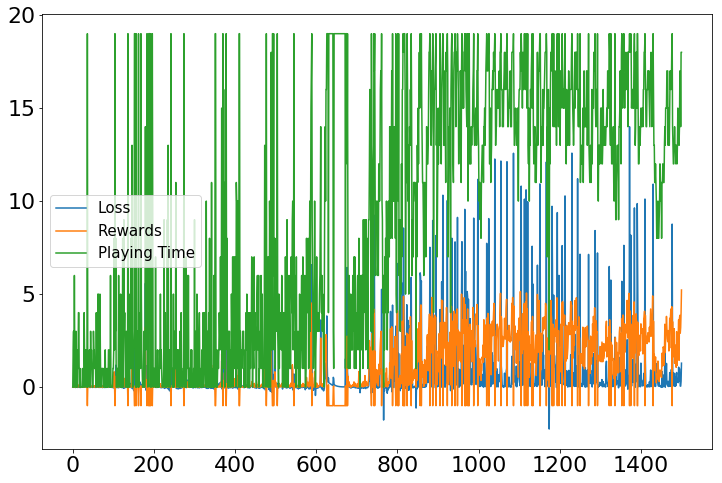

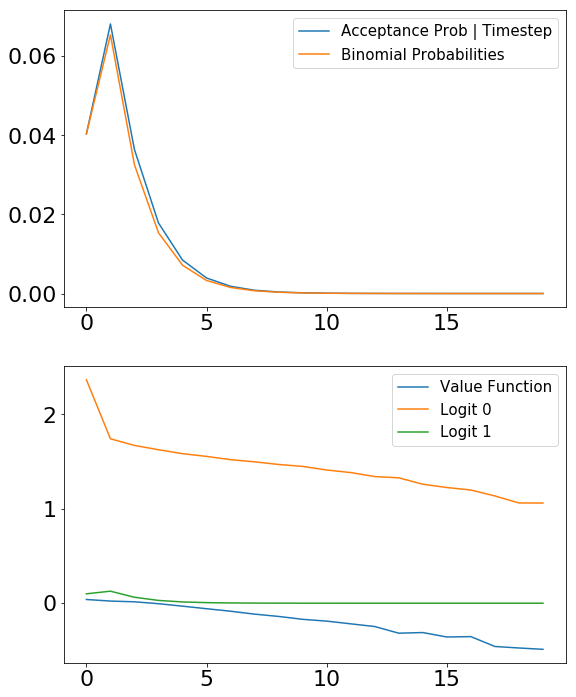

In [4]:
c = 0.3
discount = 1
Net = train(1501,c,discount,LR = 0.00005)
plot_training(c,discount)
plot_agent(c,discount,1500)

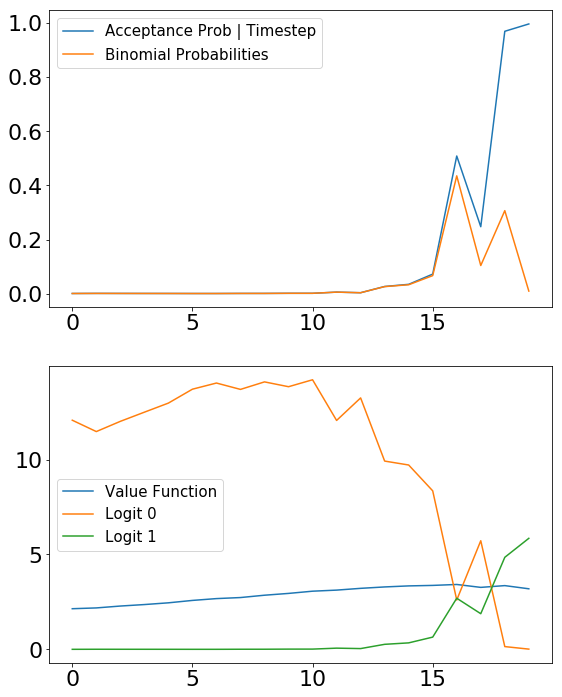

In [6]:
plot_agent(c,discount,1500)

Created Action Space
Epoch  0   with loss at  0
Episode Time is:  0.00012612342834472656
Epoch  500   with loss at  tensor(0.0403, grad_fn=<MeanBackward1>)
Episode Time is:  50.80252146720886
Epoch  1000   with loss at  tensor(0.0454, grad_fn=<MeanBackward1>)
Episode Time is:  48.090707302093506
Epoch  1500   with loss at  tensor(0.0078, grad_fn=<MeanBackward1>)
Episode Time is:  51.24037456512451


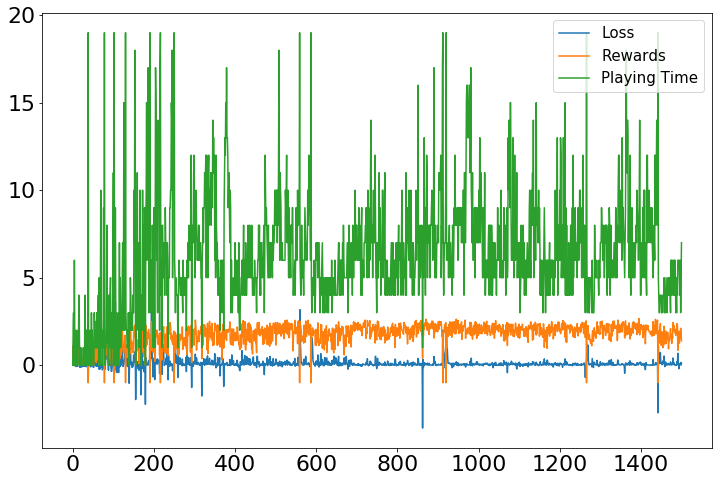

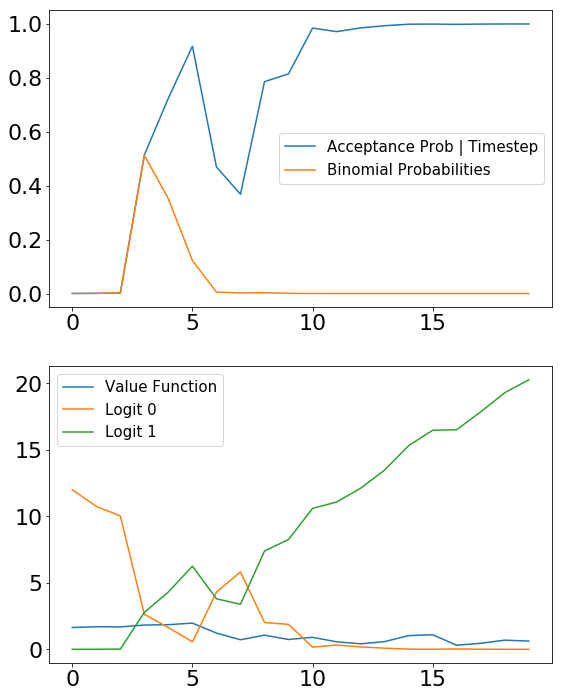

In [12]:
c = 1.0
discount = 0.94
Net = train(1501,c,discount,LR = 0.00004)
plot_training(c,discount)
plot_agent(c,discount,1500)

In [ ]:
c = 2.0
discount = 1
Net = train(4001,c,discount,0.00004)
# plot_training(c,discount)
# plot_agent(c,discount,500)
# path = "c{}-d{}".format(c,discount)
# torch.save(Net.state_dict(),path + ".th")

In [ ]:
c = 0.6
discount = 1
Net = train(4001,c,discount)
plot_training(c,discount)
plot_agent(c,discount,500)
path = "c{}-d{}".format(c,discount)
torch.save(Net.state_dict(),path + ".th")

## Discounting

In [ ]:
# c = 1.0
# discount = 0.98
# Net = train(4001,c,discount, LR = 0.00001)

c = 1.0
discount = 0.94
Net = train(4001,c,discount, LR = 0.00001)

# c = 1.0
# discount = 0.85
# Net = train(4001,c,discount, LR = 0.00001)

In [ ]:
c = 1.0
discount = 0.9
Net = train(4001,c,discount)
plot_training(c,discount)
plot_agent(c,discount,500)
path = "c{}-d{}".format(c,discount)
torch.save(Net.state_dict(),path + ".th")

In [ ]:
c = 1.0
discount = 0.75
Net = train(4001,c,discount)
plot_training(c,discount)
plot_agent(c,discount,500)
path = "c{}-d{}".format(c,discount)
torch.save(Net.state_dict(),path + ".th")

In [ ]:
c = 1.0
discount = 0.75
plot_agent(c,discount,1000)

In [ ]:
c = 2.0
discount = 0.5
Net = train(4001,c,discount)
plot_training(c,discount)
plot_agent(c,discount,500)
path = "c{}-d{}".format(c,discount)
torch.save(Net.state_dict(),path + ".th")

In [ ]:
c = 2.0
discount = 0.5
plot_agent(c,discount,2500)